In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [3]:
df_og = pd.read_csv("data/spotify_history.csv")
df = df_og.copy()
df['ts'] = pd.to_datetime(df['ts'])

In [4]:
df.loc[:, 'date'] = pd.to_datetime(df['ts']).dt.date

Let's just ignore streams before 2017 strange data.

In [5]:
df = df[df['date'] >= datetime.date(2016, 8, 1)].reset_index()

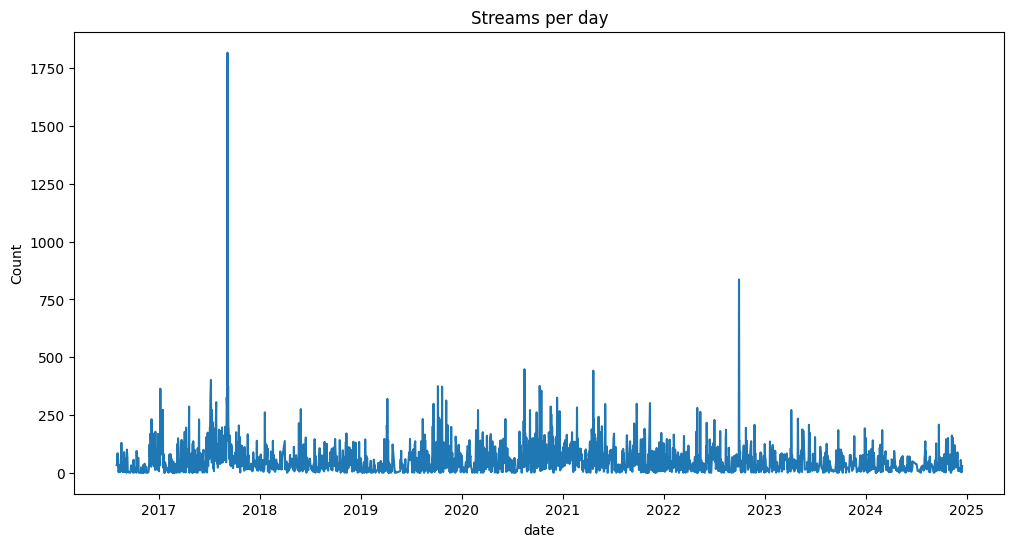

In [6]:
vc = df['date'].value_counts()
vc = vc.sort_index()

vc.plot(kind='line', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

In [7]:
t0 = df['ts'].min()
df['secs_elapsed'] = (df['ts'] - t0).dt.total_seconds()
secs_max = df['secs_elapsed'].max()
secs_3mos = 60 * 60 * 24 * 365.25 * 0.25
df['secs_elapsed'] = df['secs_elapsed'] / secs_max * secs_3mos
df['stream_time'] = t0 + pd.to_timedelta(df['secs_elapsed'], unit='s')
df['stream_date'] = df['stream_time'].dt.date

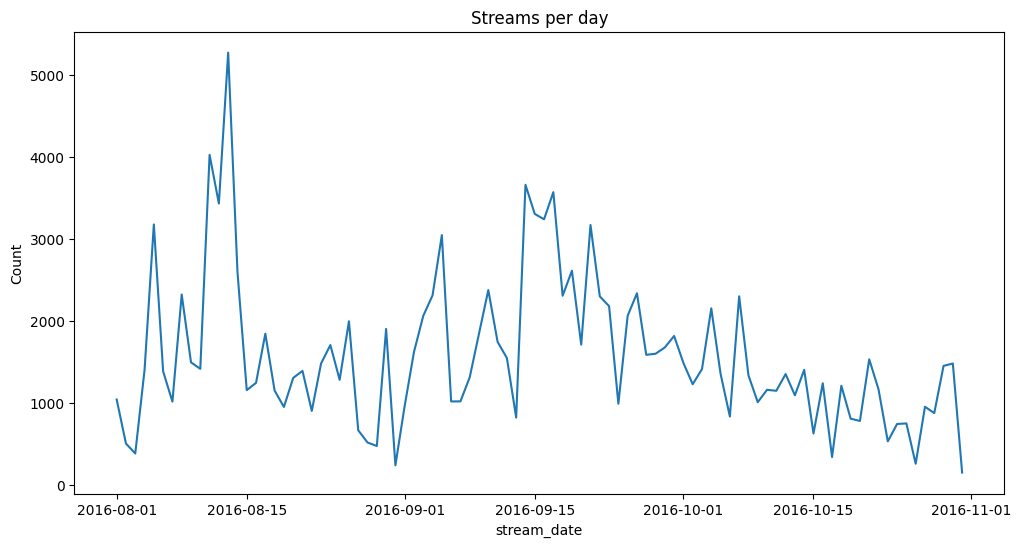

In [8]:
vc = df['stream_date'].value_counts()
vc = vc.sort_index()

vc.plot(kind='line', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

Top 30 artists have around 50% of total streams so we will just add botting to these and ignore the rest.

In [9]:
top_artists = df['artist_name'].value_counts().nlargest(30)
top_artists.sum() / df['artist_name'].value_counts().sum()


np.float64(0.4845340278875427)

In [22]:
N_streams = df['artist_name'].value_counts().nlargest(30).sum()
df['artist_name'].value_counts().nlargest(30)

artist_name
The Beatles                     13543
The Killers                      6864
John Mayer                       4768
Bob Dylan                        3790
Paul McCartney                   2697
Johnny Cash                      2476
Led Zeppelin                     2426
Radiohead                        2293
The Rolling Stones               2261
The Black Keys                   2231
Pink Floyd                       2101
Imagine Dragons                  2062
The Strokes                      1808
Coldplay                         1616
Arctic Monkeys                   1594
Lou Reed                         1557
The Velvet Underground           1505
Howard Shore                     1446
Ed Sheeran                       1431
Kings of Leon                    1376
Billy Joel                       1262
John Lennon                      1214
Elvis Presley                    1153
Arcade Fire                      1136
Mumford & Sons                   1067
Ennio Morricone                   994


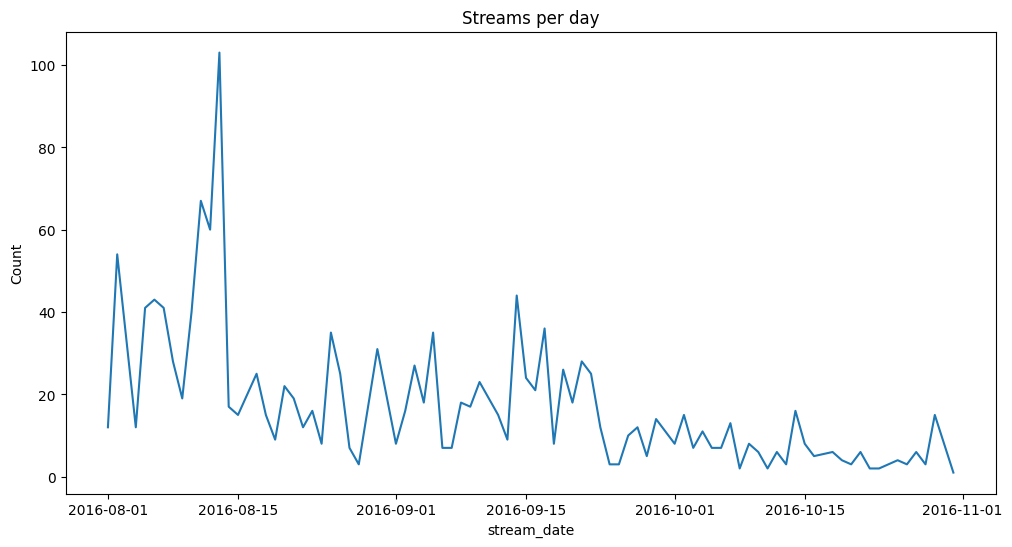

In [ ]:
vc = df[df['artist_name'] == 'The Velvet Underground']['stream_date'].value_counts()
vc = vc.sort_index()

vc.plot(kind='line', figsize=(12, 6))
plt.ylabel('Count')
plt.title('Streams per day')
plt.show()

Add in order 100 users that follow a power law of songs listened to.
Chunk data into users and maintain sessions

In [197]:
a = 3
n = 200
s = np.random.zipf(a, n)
scaled = np.round(s / s.sum() * N_streams)

In [198]:
N_streams

np.int64(70506)

In [199]:
scaled

array([ 249.,  249.,  249.,  249.,  249.,  249.,  249.,  249.,  249.,
        249.,  249.,  249.,  249.,  249.,  249.,  498.,  498.,  498.,
        249.,  498.,  249.,  249.,  249.,  249.,  249.,  498.,  747.,
        249.,  249.,  997.,  747.,  249.,  249.,  249.,  249.,  747.,
        249.,  997.,  498.,  249.,  249.,  249.,  249.,  249.,  249.,
        249.,  249.,  249.,  249.,  249.,  498.,  747.,  747., 1993.,
        249.,  997.,  249.,  249.,  249.,  249.,  249.,  249.,  249.,
        249.,  249.,  498.,  249.,  249.,  249.,  249.,  249.,  249.,
        249.,  747.,  249.,  249.,  249.,  498.,  498.,  249.,  249.,
        249.,  498.,  249.,  249.,  747.,  249.,  498.,  249.,  249.,
        249.,  249.,  249.,  249.,  249.,  249.,  249.,  249.,  249.,
        249.,  498.,  747.,  249.,  249.,  249.,  249.,  498.,  249.,
        249.,  249.,  249.,  997.,  249.,  249.,  249.,  249.,  249.,
        249.,  249.,  249.,  249.,  498.,  249.,  249.,  249.,  249.,
        249.,  249.,

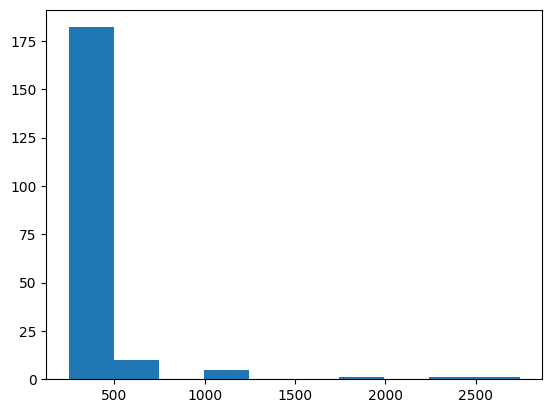

In [200]:
bins = plt.hist(scaled)

In [201]:
bin_counts = np.array([int(x) for x in bins[0]])
bin_streams = np.array([int(x) for x in bins[1][:-1]])
print(bin_counts)
print(bin_streams)
print(np.sum(bin_counts*bin_streams))

[182  10   0   5   0   0   1   0   1   1]
[ 249  498  747  996 1245 1495 1744 1993 2242 2491]
61755


now distribute the users in each bucket for differeing streams using dirichlet prop allocation

In [ ]:
alpha = 0.75


proportions = [np.random.dirichlet([alpha]*int(i)) for i in bin_counts]
raw_counts = [np.floor(proportions[i] * bin_counts[i]*bin_streams[i]) for i in range(len(bin_counts))]

for i in range(len(bin_counts)):
    diff = int(bin_counts[i] * bins[1][i] - raw_counts[i].sum())
    order = np.argsort(-proportions[i])  
    for j in range(diff):
        idx = int(order[j % bin_counts[i]])  
        raw_counts[i][idx] += 1

flat_streams = [item for sublist in raw_counts for item in sublist]

61247


In [131]:
np.sum(flat_streams)

np.float64(66476.0)

i want to either run multiple separate analyses or randomize and combine analyses. also i will use the difference between the rounded number of streams and the total streams as a number of bots to inject among the users. this will have to be bounded above and below perhaps